# RNN

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
# import seaborn as sns
import numpy as np
tf.__version__

'1.0.0'

### The basic LSTM : this is the version of the LSTM you will find implemented as the “BasicLSTMCell” in Tensorflow.

\begin{equation}
\begin{split}
i_t &= \sigma(W_ih_{t-1} + U_ix_t + b_i) \\
o_t &= \sigma(W_oh_{t-1} + U_ox_t + b_o) \\
f_t &= \sigma(W_fh_{t-1} + U_fx_t + b_f) \\
\\
\tilde{c_t}& = \phi(Wh_{t-1} + Ux_t + b)\\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t\\
\\
h_t &= o_t \odot \phi(c_t)\\
\\
\text{rnn}_{out} & = h_t
\end{split}
\end{equation}

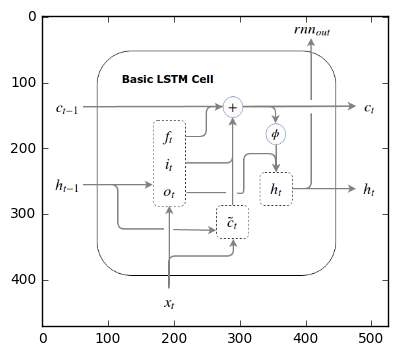

In [2]:
img=mpimg.imread("images/NH_BasicLSTMCell.png")
plt.imshow(img)

In [3]:
# """
# Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
# BSD License
# http://karpathy.github.io/2015/05/21/rnn-effectiveness/
# """
# import numpy as np

# # data I/O
# data = open('dataset/input.txt', 'r').read() # should be simple plain text file
# chars = list(set(data))
# data_size, vocab_size = len(data), len(chars)
# print ('data has %d characters, %d unique.' % (data_size, vocab_size))
# char_to_ix = { ch:i for i,ch in enumerate(chars) }
# ix_to_char = { i:ch for i,ch in enumerate(chars) }

# # hyperparameters
# hidden_size = 100 # size of hidden layer of neurons
# seq_length = 25 # number of steps to unroll the RNN for
# learning_rate = 1e-1

# # model parameters
# Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden
# Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden
# Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output
# bh = np.zeros((hidden_size, 1)) # hidden bias
# by = np.zeros((vocab_size, 1)) # output bias

# def lossFun(inputs, targets, hprev):
#   """
#   inputs,targets are both list of integers.
#   hprev is Hx1 array of initial hidden state
#   returns the loss, gradients on model parameters, and last hidden state
#   """
#   xs, hs, ys, ps = {}, {}, {}, {}
#   hs[-1] = np.copy(hprev)
#   loss = 0
#   # forward pass
#   for t in range(len(inputs)):
#     xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
#     xs[t][inputs[t]] = 1
#     hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
#     ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
#     ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
#     loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
#   # backward pass: compute gradients going backwards
#   dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
#   dbh, dby = np.zeros_like(bh), np.zeros_like(by)
#   dhnext = np.zeros_like(hs[0])
#   for t in reversed(range(len(inputs))):
#     dy = np.copy(ps[t])
#     dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
#     dWhy += np.dot(dy, hs[t].T)
#     dby += dy
#     dh = np.dot(Why.T, dy) + dhnext # backprop into h
#     dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
#     dbh += dhraw
#     dWxh += np.dot(dhraw, xs[t].T)
#     dWhh += np.dot(dhraw, hs[t-1].T)
#     dhnext = np.dot(Whh.T, dhraw)
#   for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
#     np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
#   return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

# def sample(h, seed_ix, n):
#   """ 
#   sample a sequence of integers from the model 
#   h is memory state, seed_ix is seed letter for first time step
#   """
#   x = np.zeros((vocab_size, 1))
#   x[seed_ix] = 1
#   ixes = []
#   for t in range(n):
#     h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
#     y = np.dot(Why, h) + by
#     p = np.exp(y) / np.sum(np.exp(y))
#     ix = np.random.choice(range(vocab_size), p=p.ravel())
#     x = np.zeros((vocab_size, 1))
#     x[ix] = 1
#     ixes.append(ix)
#   return ixes

# n, p = 0, 0
# mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
# mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad
# smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0
# while True:
#   # prepare inputs (we're sweeping from left to right in steps seq_length long)
#   if p+seq_length+1 >= len(data) or n == 0: 
#     hprev = np.zeros((hidden_size,1)) # reset RNN memory
#     p = 0 # go from start of data
#   inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
#   targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

#   # sample from the model now and then
#   if n % 100 == 0:
#     sample_ix = sample(hprev, inputs[0], 200)
#     txt = ''.join(ix_to_char[ix] for ix in sample_ix)
#     print ('----\n %s \n----' % (txt, ))

#   # forward seq_length characters through the net and fetch gradient
#   loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
#   smooth_loss = smooth_loss * 0.999 + loss * 0.001
#   if n % 100 == 0: print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress)
  
#   # perform parameter update with Adagrad
#   for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], 
#                                 [dWxh, dWhh, dWhy, dbh, dby], 
#                                 [mWxh, mWhh, mWhy, mbh, mby]):
#     mem += dparam * dparam
#     param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

#   p += seq_length # move data pointer
#   n += 1 # iteration counter 

# From http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html

## Outline of the data
In this post, we’ll be building a no frills RNN that accepts a binary sequence X and uses it to predict a binary sequence Y. The sequences are constructed as follows:

- Input sequence ($X$): 
  - At time step t, $X_t$ has a 50% chance of being 1 (and a 50% chance of being 0). E.g., $X$ might be [1, 0, 0, 1, 1, 1 … ].
- Output sequence ($Y$): 
  - At time step t, $Y_t$ has a base 50% chance of being 1 (and a 50% base chance to be 0). The chance of $Y_t$ being 1 is increased by 50% (i.e., to 100%) if $X_{t−3}$ is 1, and decreased by 25% (i.e., to 25%) if $X_{t−8}$ is 1. If both $X_{t−3}$ and $X_{t−8}$ are 1, the chance of $Y_t$ being 1 is 50% + 50% - 25% = 75%.  
  
Thus, there are two dependencies in the data: one at t-3 (3 steps back) and one at t-8 (8 steps back).

This data is simple enough that we can calculate the expected cross-entropy loss for a trained RNN depending on whether or not it learns the dependencies:

- If the network learns no dependencies, it will correctly assign a probability of 62.5% to 1, for an expected cross-entropy loss of about 0.66.
- If the network learns only the first dependency (3 steps back) but not the second dependency, it will correctly assign a probability of 87.5%, 50% of the time, and correctly assign a probability of 62.5% the other 50% of the time, for an expected cross entropy loss of about 0.52.
- If the network learns both dependencies, it will be 100% accurate 25% of the time, correctly assign a probability of 50%, 25% of the time, and correctly assign a probability of 75%, 50% of the time, for an expected cross extropy loss of about 0.45.


In [4]:
print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.661563238158
- learns first dependency:   0.519166699707
- learns both dependencies:  0.454454367449


In [5]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [6]:

def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

# Model

In [7]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)
# rnn_inputs
# tf.concat([rnn_inputs[0], init_state], 1)

In [8]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell.py
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [9]:
"""
Adding rnn_cells to graph

This is a simplified version of the "rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [10]:
"""
Predictions, loss, training step

Losses and total_loss are simlar to the "sequence_loss_by_example" and "sequence_loss"
functions, respectively, from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/seq2seq.py
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list labels
y_as_list = [tf.squeeze(i, squeeze_dims=[1]) for i in tf.split(y, num_steps, 1)]

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit,labels=label) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [15]:
"""
Function to train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses



EPOCH 0
Average loss at step 100 for last 250 steps: 0.6343939358
Average loss at step 200 for last 250 steps: 0.590260666609
Average loss at step 300 for last 250 steps: 0.58313903451
Average loss at step 400 for last 250 steps: 0.553407917619
Average loss at step 500 for last 250 steps: 0.524102423489
Average loss at step 600 for last 250 steps: 0.524950602055
Average loss at step 700 for last 250 steps: 0.521837845147
Average loss at step 800 for last 250 steps: 0.519368293285
Average loss at step 900 for last 250 steps: 0.521072593629


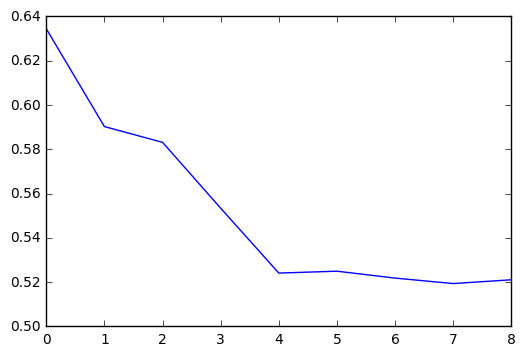

In [16]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

In [24]:
from tensorflow import basic_rnn
def plot_learning_curve(num_steps, state_size=4, epochs=1):
    global losses, total_loss, final_state, train_step, x, y, init_state
    tf.reset_default_graph()
    g = tf.get_default_graph()
    losses, total_loss, final_state, train_step, x, y, init_state = \
        basic_rnn.setup_graph(g,
            basic_rnn.RNN_config(num_steps=num_steps, state_size=state_size))
    res = train_network(epochs, num_steps, state_size=state_size, verbose=False)
    plt.plot(res)

ImportError: cannot import name 'basic_rnn'